<a href="https://colab.research.google.com/github/rajneeshanand/pytorch_RJ/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
#convert MNIST image files into Tensor of a d-dimensions
# (images, height, width, color)

transform = transforms.ToTensor()

In [69]:
#Train data
train_data = datasets.MNIST(root = '/cnn_data', train=True, download=True, transform=transform)




In [70]:
#Test data
test_data = datasets.MNIST(root = '/cnn_data', train=False, download=True, transform=transform)


In [71]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [72]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [73]:
pwd

'/content/cnn_data'

In [74]:
ls

MNIST/


In [75]:
cd cnn_data/

[Errno 2] No such file or directory: 'cnn_data/'
/content/cnn_data


In [76]:
ls

MNIST/


In [77]:
#create a small batch size for images

train_loader = DataLoader(train_data, batch_size =10, shuffle=True)
test_loader = DataLoader(test_data, batch_size =10, shuffle=False)

In [78]:
#define our CNN model
#Describe C-layer and what it's doing

conv1 = nn.Conv2d(1, 6, 3, 1) #i/o, o/p, kernal, shift
conv2 = nn.Conv2d(6, 16, 3, 1)


In [79]:
#Grab 1 MNIST image

for i, (X_train, y_train) in enumerate(train_data):
  break

In [80]:
X_train.shape

torch.Size([1, 28, 28])

In [81]:
x = X_train.view(1,1,28,28)

In [82]:
#lets perform our first convolution

x = F.relu(conv1(x)) #Rectified linear unit for our activation func

In [83]:
#1 single image, 6 is the filter we asked for, 26x26 (2 dropped bcz of padding)
x.shape

torch.Size([1, 6, 26, 26])

In [84]:
#pass thru the pooling layer

x = F.max_pool2d(x,2,2) #kernal of 2 and stride of 2

In [85]:
x.shape #26/2 =13

torch.Size([1, 6, 13, 13])

In [86]:
#do our second convolutional layer
x = F.relu(conv2(x))

In [87]:
x.shape  #we did not set padding so we loose 2 pixel out of the image

torch.Size([1, 16, 11, 11])

In [88]:
#pooling layer
x = F.max_pool2d(x,2,2)

In [89]:
x.shape #11/2 =5.5 but we have to round down

torch.Size([1, 16, 5, 5])

In [90]:
#model class
class convolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    #second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    #Re-view to faltten it out
    X= X.view(-1, 16*5*5) # negative one to say

    #fully connected layer
    X= F.relu(self.fc1(X))
    X= F.relu(self.fc2(X))
    X= self.fc3(X)

    return F.log_softmax(X, dim=1)





In [91]:
torch.manual_seed(41)
model = convolutionalNetwork()
model

convolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [92]:
#loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #smaller lr, longer it takes

In [93]:
import time
start_time =time.time()

#create variables to track things
epochs =5
train_losses =[]
test_losses=[]
train_correct =[]
test_correct=[]


#for loop of epochs
for i in range(epochs):
  trn_corr =0
  tst_corr =0

  #training
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    y_pred = model(X_train) #get pred values from training set, not fatten
    loss = criterion(y_pred, y_train) # compare pred to correct ans

    predicted = torch.max(y_pred.data, 1)[1] # add up num of corr pred
    batch_corr = (predicted == y_train).sum() #how many we got correct from batch
    trn_corr += batch_corr
     #keep track as we go along in training

    #update optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print out some results

    if b%600 ==0:
      print(f'epoc: {i} Batch:{b} Loss: {loss.item()}')

train_losses.append(loss)
train_correct.append(trn_corr)

#Test
with torch.no_grad():
  for b, (x_test, y_test) in enumerate(test_loader):
    y_val = model(x_test)
    predicted = torch.max(y_val.data, 1)[1] #Add up corr pred
    tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

loss = criterion(y_val, y_test)
test_losses.append(loss)
test_correct.append(tst_corr)



current_time = time.time()
total_time = current_time-start_time
print(f'training took: {total_time/60} minutes!')

epoc: 0 Batch:600 Loss: 0.1623610556125641
epoc: 0 Batch:1200 Loss: 0.1502392590045929
epoc: 0 Batch:1800 Loss: 0.4744560718536377
epoc: 0 Batch:2400 Loss: 0.14238706231117249
epoc: 0 Batch:3000 Loss: 0.007758188061416149
epoc: 0 Batch:3600 Loss: 0.3836284875869751
epoc: 0 Batch:4200 Loss: 0.0038223876617848873
epoc: 0 Batch:4800 Loss: 0.0021286322735249996
epoc: 0 Batch:5400 Loss: 0.0569545142352581
epoc: 0 Batch:6000 Loss: 0.00038789428072050214
epoc: 1 Batch:600 Loss: 0.06289136409759521
epoc: 1 Batch:1200 Loss: 0.010614877566695213
epoc: 1 Batch:1800 Loss: 0.03243611007928848
epoc: 1 Batch:2400 Loss: 0.012448625639081001
epoc: 1 Batch:3000 Loss: 0.000640809943433851
epoc: 1 Batch:3600 Loss: 0.0020938280504196882
epoc: 1 Batch:4200 Loss: 0.3140248656272888
epoc: 1 Batch:4800 Loss: 0.020231451839208603
epoc: 1 Batch:5400 Loss: 0.0031914091669023037
epoc: 1 Batch:6000 Loss: 0.0009488927898928523
epoc: 2 Batch:600 Loss: 0.04242878407239914
epoc: 2 Batch:1200 Loss: 0.000786997377872467


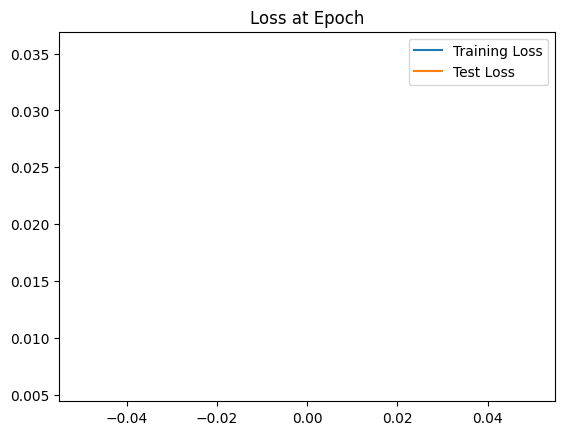

In [94]:
import torch

train_losses = [t1.item() if isinstance(t1, torch.Tensor) else t1 for t1 in train_losses]
test_losses = [t1.item() if isinstance(t1, torch.Tensor) else t1 for t1 in test_losses]
#graph the loss at epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss at Epoch')
plt.legend()

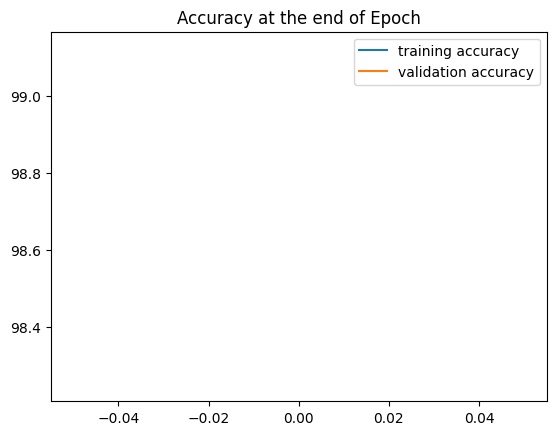

In [95]:
plt.plot([t/600 for t in train_correct], label ='training accuracy')
plt.plot([t/100 for t in test_correct], label ='validation accuracy')
plt.title('Accuracy at the end of Epoch')
plt.legend()